# 1. VAE Implementation

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

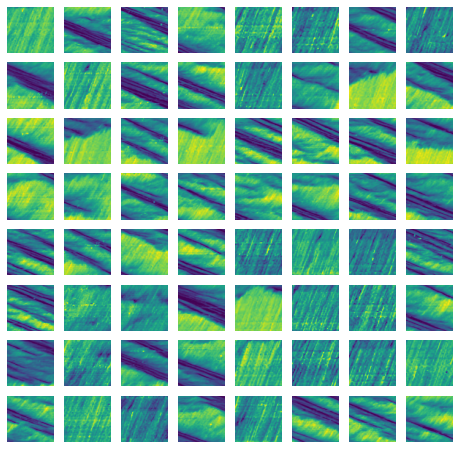

In [2]:
data = np.load('dataset/i24speedcontour_64.npy')
data = torch.tensor(data, dtype=torch.float32)
data = data.permute(0, 1, 3, 2)
data[data > 145] = 145

data_min = data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0], origin="lower" )
        ax[i, j].axis("off")

In [3]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

![alt text](img/VAE_edit.png "Title")

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(4, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc_fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.enc_fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 4, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.enc_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        z = self.dec_conv(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

$
\begin{align}
\mathcal{L}(\mathbf{x};\theta,\phi) &=  \mathbb{E}_{\mathbf{z} \sim q_{\phi} (\mathbf{z} | \mathbf{x})} \left[ \log p_{\theta}(\mathbf{x}|\mathbf{z})  \right]- D_{KL} \left( q_{\phi} \left(\mathbf{z}|\mathbf{x} \right) || p (\mathbf{z})  \right) \\
&= \text{Reconstruction Loss + Regularization}
\end{align}
$


$D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2)) || \mathcal N_2({\mu_2, \sigma_2}^2))=\log {\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-{1\over 2}$

$D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2))||\mathcal N(0, 1))=- \frac{1}{2}\left(1 + 2\log \sigma_1- \mu_1^2 -\sigma_1^2   \right)
$

In [5]:
# Hyperparameters
z_dim = 64  # Size of the noise vector
lr = 0.00035
beta1 = 0.8

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(z_dim).to(device)

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

# Define the loss function
def criterion(recon_x, x, mu, logvar):
    # Reconstruction Loss: Measures how well the decoded output matches the input.
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # regularization: Measures how much the learned latent space diverges from the prior normal distribution.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # we set logvar as 2*log(\sigma)
    return recon_loss + kl_loss

In [6]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)
        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*batch_size

    print(f'Epoch [{epoch+1:02}/{num_epochs}], Loss {train_loss / train_size:>11.4f}')

# Save the model after training
torch.save(model.state_dict(), 'models/vae_model.pth')
print("VAE model saved.")

Epoch [01/50], Loss  58883.3265
Epoch [02/50], Loss  12915.4566
Epoch [03/50], Loss  10917.0350
Epoch [04/50], Loss   9967.8359
Epoch [05/50], Loss   9123.5747
Epoch [06/50], Loss   8721.2791
Epoch [07/50], Loss   8263.3478
Epoch [08/50], Loss   7944.8188
Epoch [09/50], Loss   7508.5704
Epoch [10/50], Loss   7294.3673
Epoch [11/50], Loss   7147.5509
Epoch [12/50], Loss   6859.6403
Epoch [13/50], Loss   6787.8054
Epoch [14/50], Loss   6537.9711
Epoch [15/50], Loss   6487.3312
Epoch [16/50], Loss   6354.9976
Epoch [17/50], Loss   6328.4372
Epoch [18/50], Loss   6212.3162
Epoch [19/50], Loss   6101.4006
Epoch [20/50], Loss   5987.2641
Epoch [21/50], Loss   5974.5164
Epoch [22/50], Loss   5889.9256
Epoch [23/50], Loss   5875.8623
Epoch [24/50], Loss   5801.1238
Epoch [25/50], Loss   5771.5696
Epoch [26/50], Loss   5710.3357
Epoch [27/50], Loss   5722.1370
Epoch [28/50], Loss   5640.1475
Epoch [29/50], Loss   5605.5814
Epoch [30/50], Loss   5586.7393
Epoch [31/50], Loss   5572.7838
Epoch [3

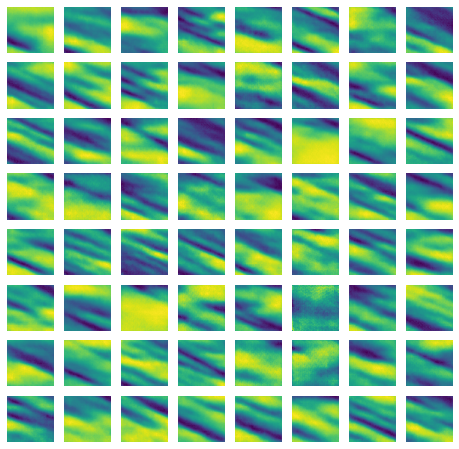

In [7]:
z_dim = 64
device = "cpu"

model = VAE(z_dim).to(device)
model.load_state_dict(torch.load('models/vae_model.pth', map_location="cpu"))
model.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")
plt.show()